## 1. 导入模块

## 1. 导入模块

In [1]:
import sys
import os

# 确保可以导入 moe_booststrap 模块
project_root = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == 'moe_booststrap' else os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# 清除缓存的模块
for mod in list(sys.modules.keys()):
    if 'moe_booststrap' in mod:
        del sys.modules[mod]

import numpy as np
import pandas as pd
import torch

# 导入 MoE Bootstrap 模块
from moe_booststrap import (
    DEVICE, SEED, DATA_PATH, DIST_COLS, FEATURE_COLS, OUTPUT_DIR,
    NUM_EXPERTS, TOP_K, HIDDEN_SIZE, DROPOUT, AUX_LOSS_WEIGHT, LR, WD, MAX_EPOCHS, PATIENCE,
    BOOTSTRAP_B, BOOTSTRAP_CI, BOOTSTRAP_EPOCH_SCALE,
    GRID_NUM_EXPERTS, GRID_TOP_K, GRID_HIDDEN_SIZE, GRID_EPOCHS,
    load_and_split_data, make_weights_from_N,
    MoE,
    soft_cross_entropy, weighted_soft_cross_entropy, expert_diversity_penalty,
    compute_metrics, compute_per_bin_metrics, compute_per_sample_metrics,
    set_seed, expert_output_separation_js, train_moe, evaluate,
    specialization_search, expert_topk_grid_search,
    bootstrap_predict, bootstrap_summary, compute_confidence_scores, bootstrap_evaluate,
    plot_training_history, plot_random_sample_distributions, plot_error_analysis,
    analyze_expert_usage, compute_expert_outputs, plot_expert_gate_heatmap,
    plot_sample_expert_decomposition, plot_holdout_bar_with_ci, plot_holdout_violin,
    plot_uncertainty, plot_grid_search_results, plot_expert_specialization_analysis,
    plot_expert_parallel_coordinates,
    save_predictions, save_bootstrap_predictions, save_holdout_predictions_with_ci,
    save_uncertainty_arrays, write_bootstrap_report, generate_summary_report, format_metrics_table,
)

print(f"Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"Data path: {DATA_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Device: cpu
PyTorch version: 2.9.1
Data path: /Users/luoyiti/Project/MCM_2023_C/data/mcm_processed_data.csv
Output dir: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output


## 2. 数据加载与预处理

In [2]:
# 设置随机种子
set_seed(SEED)

# 加载数据
result = load_and_split_data(
    data_path=DATA_PATH,
    holdout_word="eerie",
    test_size=0.30,
    val_ratio=0.50,
)

# 解包数据
X_train, X_val, X_test = result[0], result[1], result[2]
P_train, P_val, P_test = result[3], result[4], result[5]
N_train, N_val, N_test = result[6], result[7], result[8]
holdout_pack, scaler = result[9], result[10]

# 提取 Holdout 数据
if holdout_pack is not None:
    X_holdout = holdout_pack["X"]
    P_holdout = holdout_pack["P_true"]
else:
    X_holdout, P_holdout = None, None

# 计算样本权重
if N_train is not None:
    train_weights = make_weights_from_N(N_train, mode="sqrt")
else:
    train_weights = np.ones(len(X_train), dtype=np.float32)

print(f"\n数据集规模:")
print(f"  训练集: {len(X_train)} 样本")
print(f"  验证集: {len(X_val)} 样本")
print(f"  测试集: {len(X_test)} 样本")
if X_holdout is not None:
    print(f"  Holdout: {len(X_holdout)} 样本 (eerie)")
print(f"  特征数: {X_train.shape[1]}")
print(f"  输出维度: {P_train.shape[1]}")

[Holdout] 已抽取 1 条 'eerie' 样本，不参与 train/val/test

数据集规模:
  训练集: 250 样本
  验证集: 54 样本
  测试集: 54 样本
  Holdout: 1 样本 (eerie)
  特征数: 55
  输出维度: 7


## 3. 模型配置与训练

In [3]:
# 显示当前配置
NUM_EXPERTS = 2
TOP_K = 1
config = {
    "num_experts": NUM_EXPERTS,
    "top_k": TOP_K,
    "hidden_size": HIDDEN_SIZE,
    "dropout": DROPOUT,
    "aux_loss_weight": AUX_LOSS_WEIGHT,
    "lr": LR,
    "wd": WD,
    "max_epochs": MAX_EPOCHS,
    "patience": PATIENCE,
}
print("模型配置:")
for k, v in config.items():
    print(f"  {k}: {v}")

模型配置:
  num_experts: 2
  top_k: 1
  hidden_size: 256
  dropout: 0.1
  aux_loss_weight: 0.0005
  lr: 0.001
  wd: 0.0001
  max_epochs: 500
  patience: 60


In [4]:
# 将权重转为 tensor
Wtr = torch.tensor(train_weights, device=DEVICE) if train_weights is not None else None

# 训练模型
model, train_info_dict = train_moe(
    X_train, P_train, X_val, P_val,
    Wtr=Wtr,
    num_experts=NUM_EXPERTS,
    top_k=TOP_K,
    hidden_size=HIDDEN_SIZE,
    aux_coef=AUX_LOSS_WEIGHT,
    lr=LR,
    weight_decay=WD,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    device=DEVICE,
    verbose=True,
)

# 提取训练信息
train_losses = train_info_dict["train_losses"]
val_losses = train_info_dict["val_losses"]
bad = train_info_dict["bad"]

[MoE] epoch= 50 train_loss=1.5544 val_loss=1.5828 aux_loss=0.000001 div_pen=0.000062 output_div=0.9999
[MoE] epoch= 50 expert_js_separation=0.1237
[MoE] epoch=100 train_loss=1.5425 val_loss=1.5791 aux_loss=0.000025 div_pen=0.000144 output_div=0.9999
[MoE] epoch=100 expert_js_separation=0.0999
[MoE] epoch=150 train_loss=1.5376 val_loss=1.5774 aux_loss=0.000064 div_pen=0.000262 output_div=0.9999
[MoE] epoch=150 expert_js_separation=0.0713
[MoE] epoch=200 train_loss=1.5345 val_loss=1.5804 aux_loss=0.000036 div_pen=0.000344 output_div=1.0000
[MoE] epoch=200 expert_js_separation=0.1377
[MoE] Early stopping at epoch 210.


## 4. 训练曲线可视化

[Plot] 训练曲线已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/training_history.png


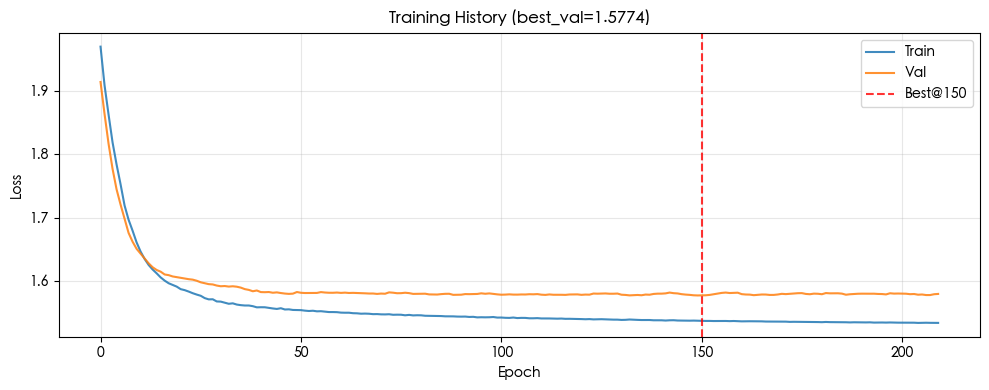


最佳轮次: 150
最佳验证损失: 1.577381


In [5]:
# 绘制训练曲线
train_info = plot_training_history(
    train_losses, val_losses, bad, min(val_losses),
    save_path=os.path.join(OUTPUT_DIR, "training_history.png"),
    show=True,
)
print(f"\n最佳轮次: {train_info['best_epoch']}")
print(f"最佳验证损失: {train_info['best_val_loss']:.6f}")

## 5. 测试集评估

In [6]:
# 评估测试集
P_pred, test_metrics = evaluate(model, X_test, P_test, device=DEVICE)

print(format_metrics_table(test_metrics, "测试集评估指标"))


[MoE] 测试集评估
  mae: 0.031483
  rmse: 0.059935
  mse: 0.003592
  kl: 0.389356
  js_mean: 0.108027
  tv_distance: 0.110191
  cos_sim: 0.969221
  r2: -0.139026
  max_error: 0.742573

测试集评估指标
-------------------------------
mae         :     0.031483
rmse        :     0.059935
mse         :     0.003592
kl          :     0.389356
js_mean     :     0.108027
tv_distance :     0.110191
cos_sim     :     0.969221
r2          :    -0.139026
max_error   :     0.742573
-------------------------------


[Plot] 随机样本分布对比图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/sample_distributions.png


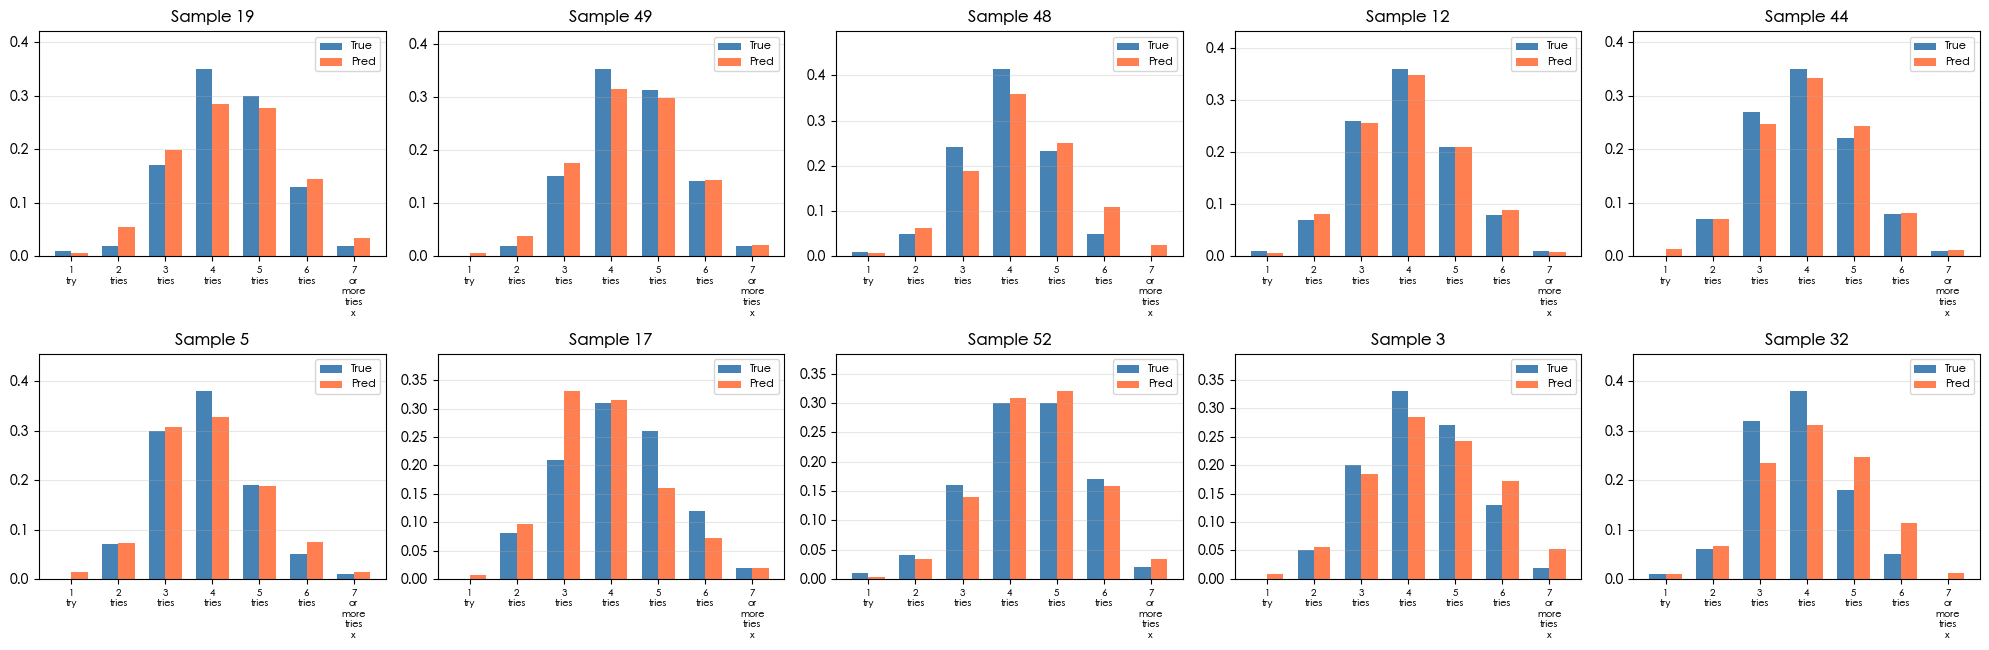

[19, 49, 48, 12, 44, 5, 17, 52, 3, 32]

In [7]:
# 随机样本分布对比
plot_random_sample_distributions(
    P_test, P_pred, sample_size=10,
    save_path=os.path.join(OUTPUT_DIR, "sample_distributions.png"),
    show=True,
)

[Plot] 误差分析图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/error_analysis.png


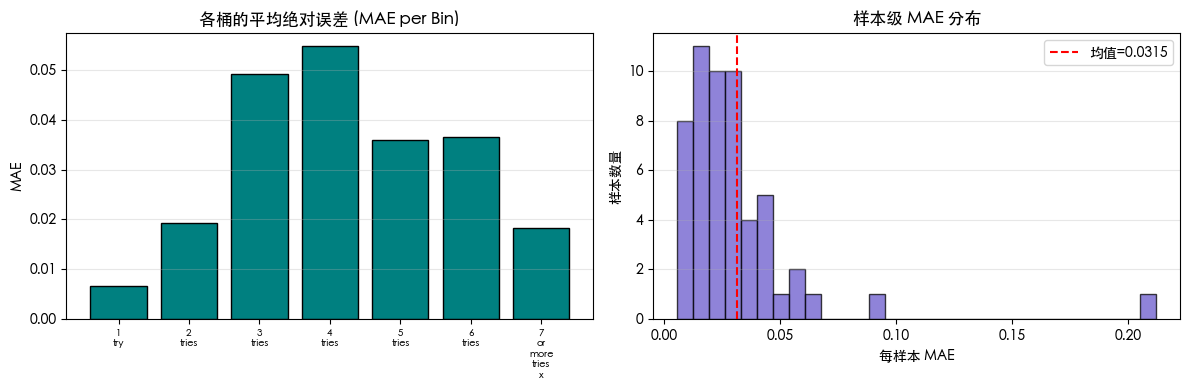


各桶 MAE:
  1_try: 0.006628
  2_tries: 0.019172
  3_tries: 0.049221
  4_tries: 0.054717
  5_tries: 0.035853
  6_tries: 0.036558
  7_or_more_tries_x: 0.018233


In [8]:
# 误差分析
error_info = plot_error_analysis(
    P_test, P_pred,
    save_path=os.path.join(OUTPUT_DIR, "error_analysis.png"),
    show=True,
)

print("\n各桶 MAE:")
for i, (col, mae) in enumerate(zip(DIST_COLS, error_info["mae_per_dim"])):
    print(f"  {col}: {mae:.6f}")

## 6. 专家分析

[Plot] 专家使用率图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/expert_usage.png


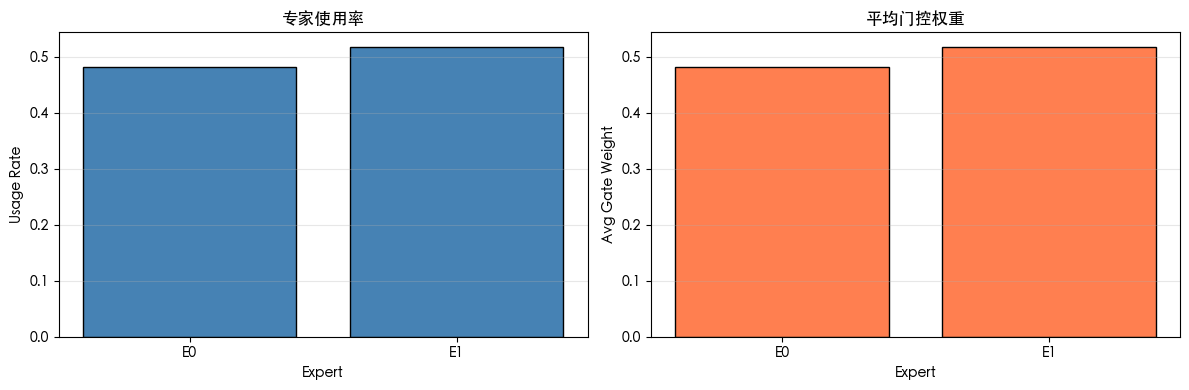


专家使用率:
  Expert 0: 使用率=48.15%, 平均权重=0.4815
  Expert 1: 使用率=51.85%, 平均权重=0.5185


In [9]:
# 分析专家使用率
expert_stats = analyze_expert_usage(
    model, X_test,
    save_path=os.path.join(OUTPUT_DIR, "expert_usage.png"),
    show=True,
    device=DEVICE,
)

print("\n专家使用率:")
for i, (usage, weight) in enumerate(zip(expert_stats["expert_usage"], expert_stats["expert_avg_weight"])):
    print(f"  Expert {i}: 使用率={usage:.2%}, 平均权重={weight:.4f}")

In [10]:
# 计算专家输出
y_experts, gates, y_mix = compute_expert_outputs(model, X_test, device=DEVICE)

print(f"\n专家输出形状:")
print(f"  y_experts: {y_experts.shape}")
print(f"  gates: {gates.shape}")
print(f"  y_mix: {y_mix.shape}")


专家输出形状:
  y_experts: (2, 54, 7)
  gates: (54, 2)
  y_mix: (54, 7)


[Plot] 专家平行坐标图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/expert_parallel_coordinates.png


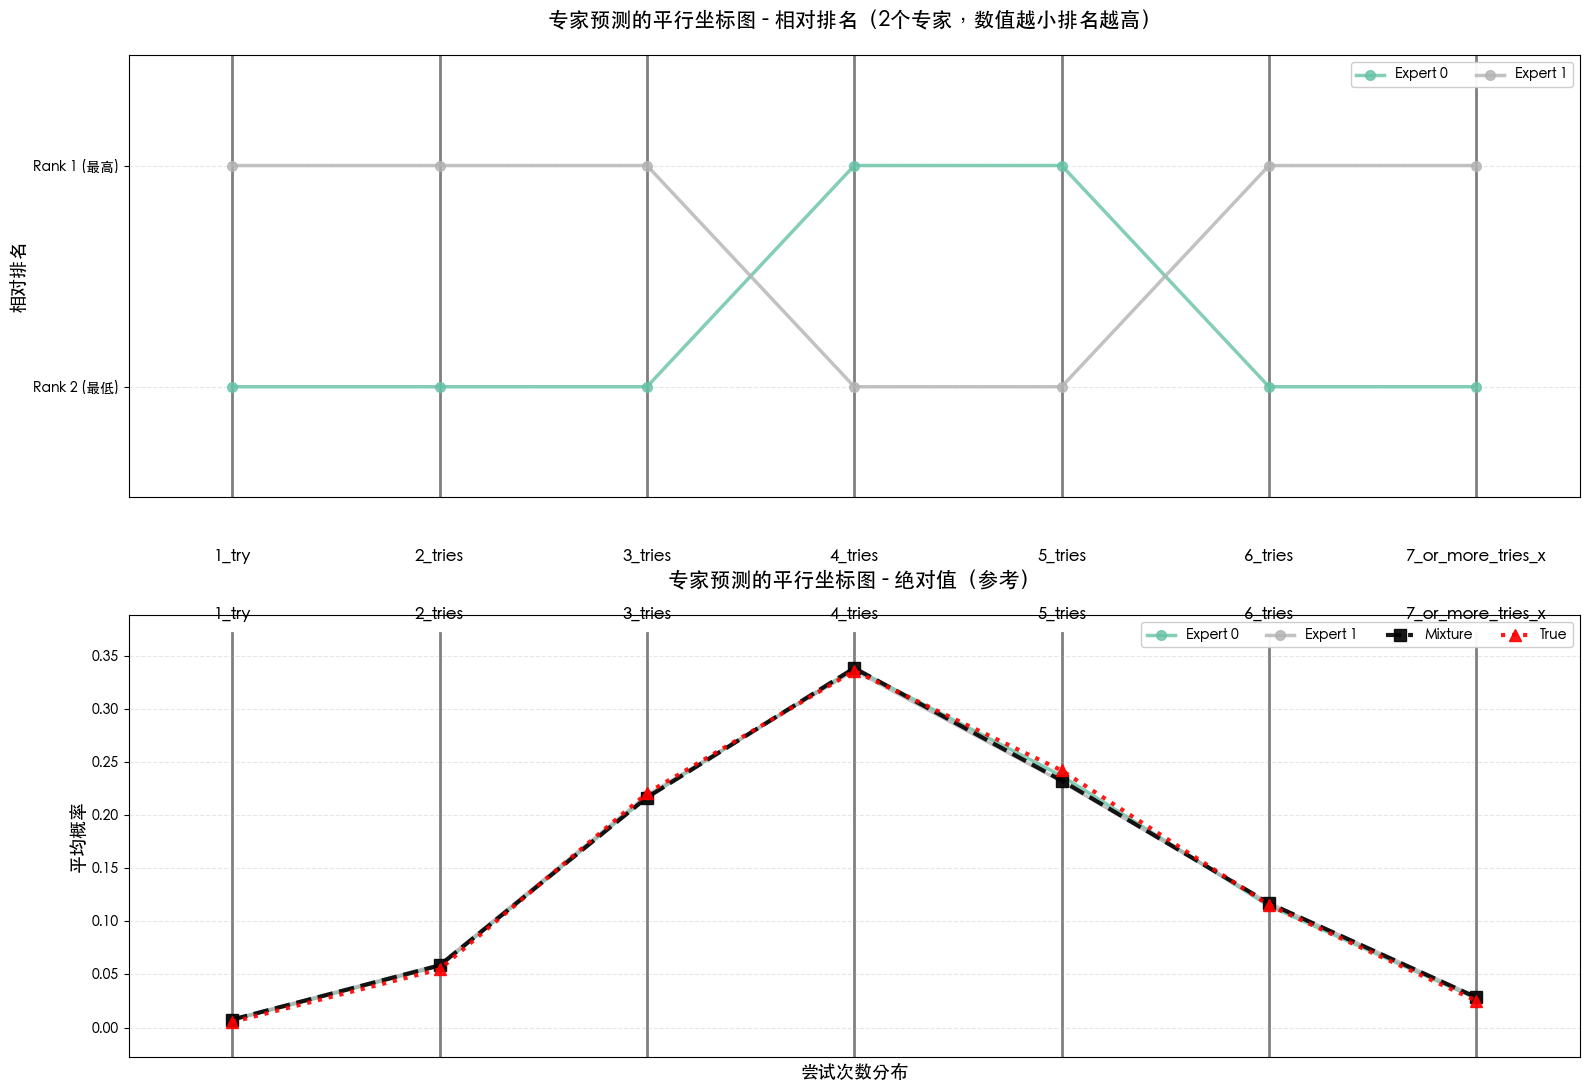


专家差异性分析（基于相对排名）:
  各专家峰值位置: ['4_tries', '4_tries']
  各专家平均排名: [1.7142857 1.2857143] (越小越好)
  各专家排名稳定性: [0.45175394 0.45175394] (越小越稳定)

专家间排名距离矩阵（基于排名的欧氏距离）:
[[0.         2.64575124]
 [2.64575124 0.        ]]


In [11]:
# 使用平行坐标图展示专家差异 - 基于相对排名
# 平行坐标图将每个尝试次数作为一个坐标轴
# 每个专家在各个轴上的值表示其在该尝试次数上的相对排名（1=最高，3=最低）
# 通过排名折线的差异来凸显专家的专业化特征

parallel_stats = plot_expert_parallel_coordinates(
    y_experts, y_mix, P_test,
    save_path=os.path.join(OUTPUT_DIR, "expert_parallel_coordinates.png"),
    show=True,
)

print(f"\n专家差异性分析（基于相对排名）:")
print(f"  各专家峰值位置: {[DIST_COLS[p] for p in parallel_stats['peak_positions']]}")
print(f"  各专家平均排名: {parallel_stats['avg_rank']} (越小越好)")
print(f"  各专家排名稳定性: {parallel_stats['rank_stability']} (越小越稳定)")
print(f"\n专家间排名距离矩阵（基于排名的欧氏距离）:")
print(parallel_stats['rank_distances'])

### 6.1 专家差异可视化：平行坐标图（基于相对排名）

**改进的平行坐标图**通过相对排名展示专家的差异性，**支持2-4个专家的可视化**：
- **垂直坐标轴**：每个尝试次数（1_try, 2_tries, ... 7_or_more_tries）是一个独立的**垂直坐标轴**
- **排名值**：每个专家在各个轴上的值表示其在该尝试次数上的相对排名（1=最高，num_experts=最低）
- **折线连接**：每个专家的排名通过折线连接，形成排名变化轨迹
- **差异识别**：通过观察折线的交叉和分离，识别专家在不同尝试次数上的相对优劣

**上图（相对排名）**：展示各专家在每个尝试次数上的排名
- 排名越小（越接近1）表示该专家在该尝试次数上的预测值越高
- 折线交叉表示专家之间的相对排名发生变化
- Y轴反转，使排名1显示在顶部
- Y轴范围自动适应专家数量（2专家: 1-2, 3专家: 1-3, 4专家: 1-4）

**下图（绝对值参考）**：保留原始平均概率值作为参考

这种可视化方法的优势：
- **放大差异**：相对排名消除了绝对数值的影响，突出专家之间的相对差异
- **易于比较**：固定的排名范围使得跨维度的比较更加直观
- **模式识别**：交叉点清晰显示专家专业化的转折
- **灵活适配**：自动适应不同数量的专家（2-4个），颜色、图例和标签都会动态调整

[Plot] 样本分解图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/expert_decomposition.png


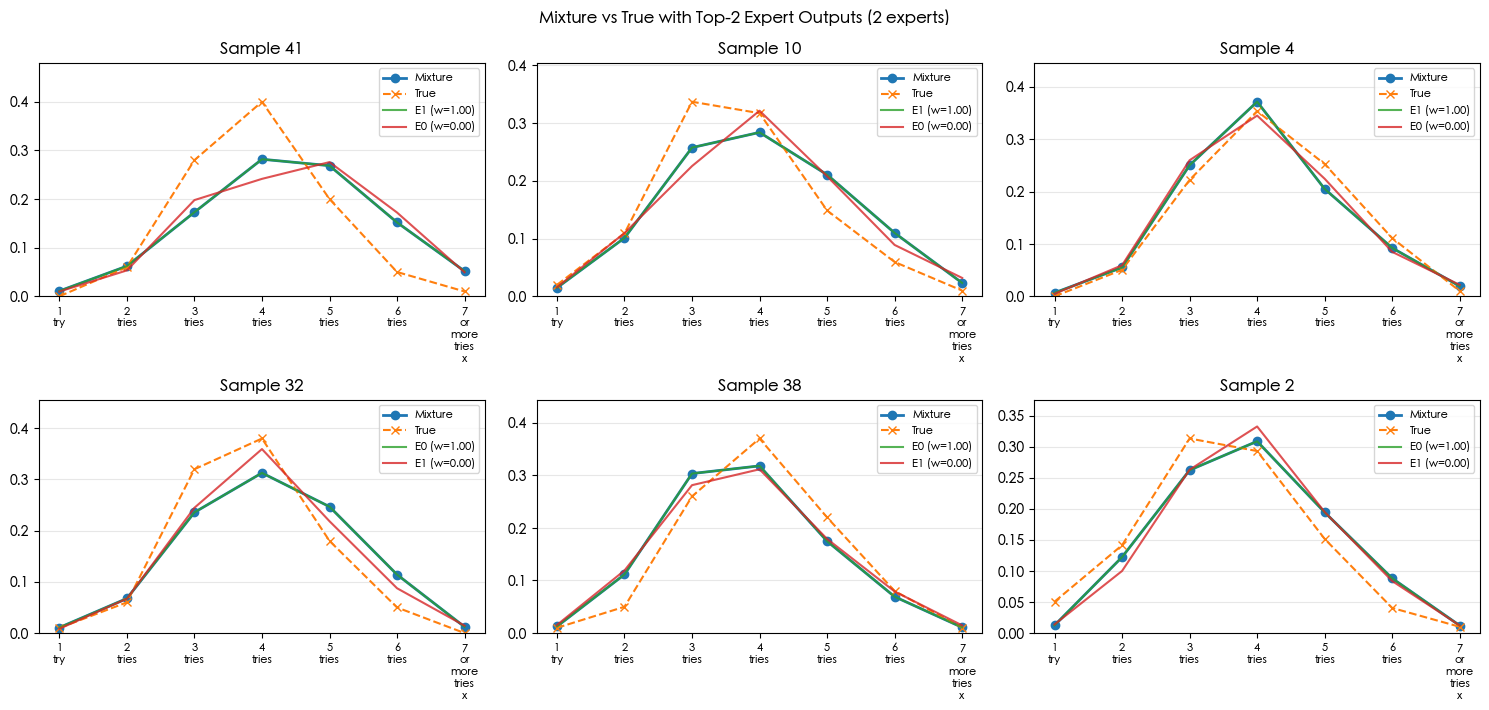

In [12]:
# 专家分解可视化
plot_sample_expert_decomposition(
    P_test, y_experts, gates, y_mix,
    save_path=os.path.join(OUTPUT_DIR, "expert_decomposition.png"),
    show=True,
    sample_size=6,
)

## 7. Bootstrap 不确定性估计

In [13]:
# Bootstrap 配置
print(f"Bootstrap 配置:")
print(f"  B (迭代次数): {BOOTSTRAP_B}")
print(f"  CI (置信区间): {BOOTSTRAP_CI}")
print(f"  Epoch Scale: {BOOTSTRAP_EPOCH_SCALE}")

Bootstrap 配置:
  B (迭代次数): 200
  CI (置信区间): 0.95
  Epoch Scale: 0.8


In [14]:
# 执行 Bootstrap（可设置较小的 B 值以加速测试）
B_RUN = min(10, BOOTSTRAP_B)  # 示例时用较小值

P_boot_test, P_boot_holdout = bootstrap_predict(
    X_train, P_train, N_train,
    X_val, P_val, N_val,
    X_test,
    X_holdout=X_holdout,
    B=B_RUN,
    num_experts=NUM_EXPERTS,
    top_k=TOP_K,
    hidden_size=HIDDEN_SIZE,
    max_epochs=int(MAX_EPOCHS * BOOTSTRAP_EPOCH_SCALE),
    verbose=True,
)

[Bootstrap] Run 1/10
[Bootstrap] Run 2/10
[Bootstrap] Run 3/10
[Bootstrap] Run 4/10
[Bootstrap] Run 5/10
[Bootstrap] Run 6/10
[Bootstrap] Run 7/10
[Bootstrap] Run 8/10
[Bootstrap] Run 9/10
[Bootstrap] Run 10/10


In [15]:
# Bootstrap 汇总
P_mean_test, P_std_test, P_low_test, P_high_test = bootstrap_summary(P_boot_test, ci_level=BOOTSTRAP_CI)
P_mean_holdout, P_std_holdout, P_low_holdout, P_high_holdout = bootstrap_summary(P_boot_holdout, ci_level=BOOTSTRAP_CI)

print(f"\n测试集 Bootstrap 结果:")
print(f"  均值形状: {P_mean_test.shape}")
print(f"  平均 CI 宽度: {(P_high_test - P_low_test).mean():.6f}")

print(f"\nHoldout Bootstrap 结果:")
print(f"  均值形状: {P_mean_holdout.shape}")
print(f"  平均 CI 宽度: {(P_high_holdout - P_low_holdout).mean():.6f}")


测试集 Bootstrap 结果:
  均值形状: (54, 7)
  平均 CI 宽度: 0.046870

Holdout Bootstrap 结果:
  均值形状: (1, 7)
  平均 CI 宽度: 0.072650


In [16]:
# Bootstrap 评估
boot_result = bootstrap_evaluate(P_boot_test, P_test, ci_level=BOOTSTRAP_CI)
boot_metrics = boot_result["metrics"]

print(format_metrics_table(boot_metrics, "Bootstrap 评估指标"))
print(f"\nCI 覆盖率: {boot_result['ci_coverage']:.2%}")


Bootstrap 评估指标
-------------------------------
mae         :     0.030734
rmse        :     0.056390
mse         :     0.003180
kl          :     0.189374
js_mean     :     0.106891
tv_distance :     0.107570
cos_sim     :     0.972388
r2          :    -0.085254
max_error   :     0.694432
-------------------------------

CI 覆盖率: 42.86%


## 8. 不确定性可视化

[Plot] 不确定性图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/test_uncertainty.png


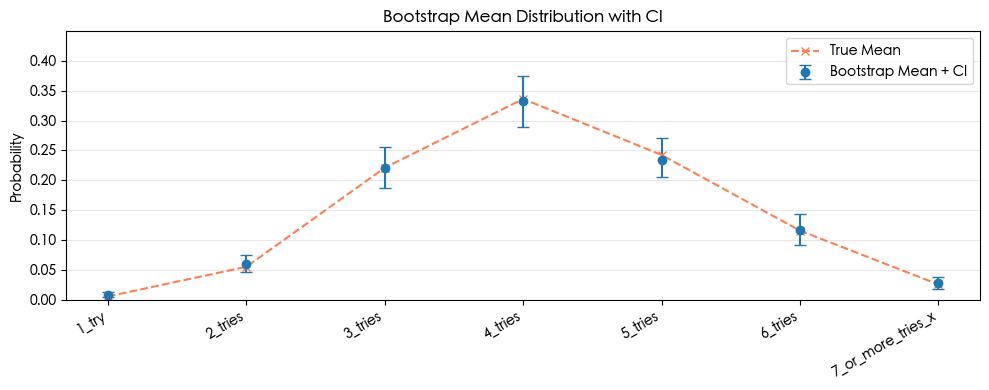

In [17]:
# 测试集整体不确定性
plot_uncertainty(
    P_mean_test, P_low_test, P_high_test, P_test,
    save_path=os.path.join(OUTPUT_DIR, "test_uncertainty.png"),
    show=True,
)

[Plot] Holdout 柱状图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/holdout_bar_ci.png


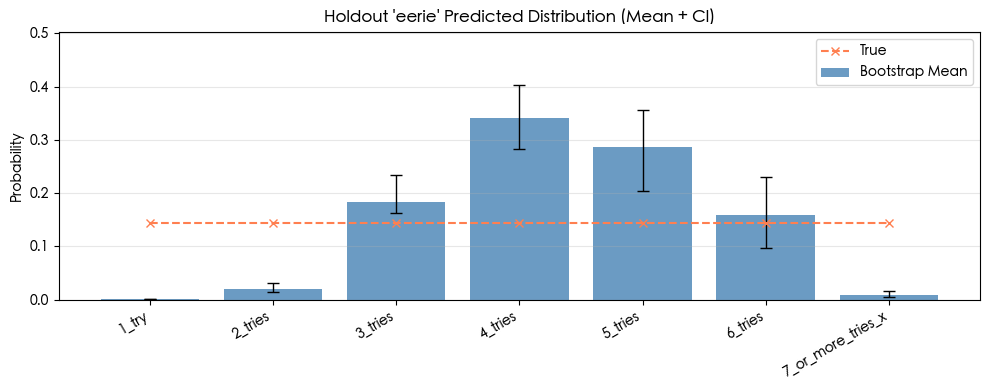

In [18]:
# Holdout 柱状图（带 CI）
plot_holdout_bar_with_ci(
    P_mean_holdout, P_low_holdout, P_high_holdout, P_holdout,
    word="eerie",
    save_path=os.path.join(OUTPUT_DIR, "holdout_bar_ci.png"),
    show=True,
)

[Plot] Holdout 小提琴图已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/holdout_violin.png


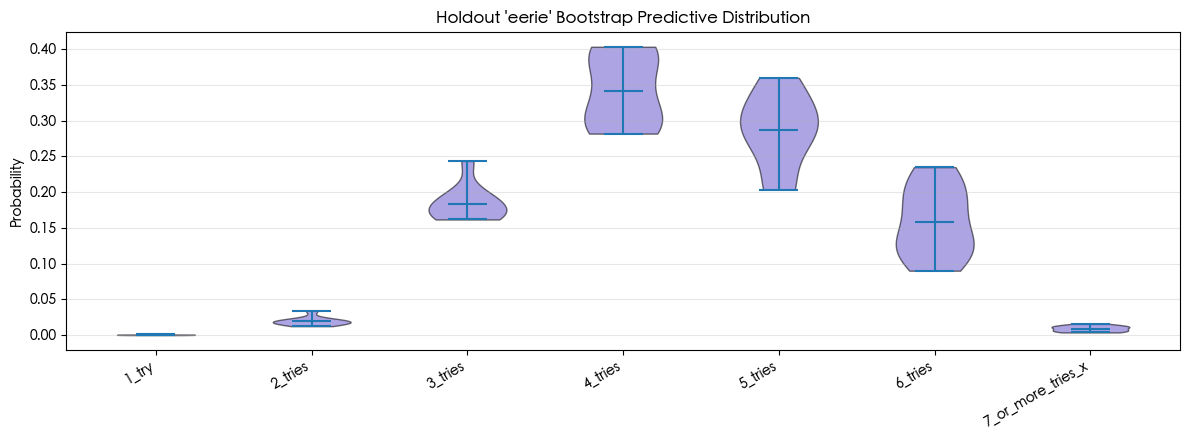

In [19]:
# Holdout 小提琴图
plot_holdout_violin(
    P_boot_holdout,
    word="eerie",
    save_path=os.path.join(OUTPUT_DIR, "holdout_violin.png"),
    show=True,
)

## 9. 保存结果

In [20]:
# 保存不确定性数组
save_uncertainty_arrays(
    P_mean_test, P_low_test, P_high_test,
    save_dir=OUTPUT_DIR,
    prefix="test",
)

# 生成综合报告
report = generate_summary_report(
    train_info={
        "best_epoch": train_info["best_epoch"],
        "best_val_loss": train_info["best_val_loss"],
        "num_experts": NUM_EXPERTS,
        "top_k": TOP_K,
        "hidden_size": HIDDEN_SIZE,
    },
    test_metrics=test_metrics,
    bootstrap_metrics=boot_metrics,
    save_path=os.path.join(OUTPUT_DIR, "summary_report.txt"),
)
print(report)

[Save] 不确定性数组已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/test_uncertainty.npz
[Report] 训练总结已保存: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output/summary_report.txt
MoE 模型训练总结报告

【训练信息】
  best_epoch: 150
  best_val_loss: 1.577381
  num_experts: 2
  top_k: 1
  hidden_size: 256

【测试集指标】
  mae: 0.031483
  rmse: 0.059935
  mse: 0.003592
  kl: 0.389356
  js_mean: 0.108027
  tv_distance: 0.110191
  cos_sim: 0.969221
  r2: -0.139026
  max_error: 0.742573

【Bootstrap 指标】
  mae: 0.030734
  rmse: 0.056390
  mse: 0.003180
  kl: 0.189374
  js_mean: 0.106891
  tv_distance: 0.107570
  cos_sim: 0.972388
  r2: -0.085254
  max_error: 0.694432



## 10. 总结

本 Notebook 完成了以下任务：

1. **数据加载**：从 CSV 加载数据，划分训练/验证/测试/Holdout 集
2. **模型训练**：使用 Sparse-gated MoE 架构训练分布预测模型
3. **模型评估**：计算 MAE、JS 散度、KL 散度等指标
4. **专家分析**：分析各专家的使用率和输出分布
5. **Bootstrap 估计**：通过 Bootstrap 方法估计预测不确定性
6. **可视化**：训练曲线、分布对比、误差分析、不确定性图
7. **结果保存**：保存预测结果和评估报告

In [21]:
import sys
import os

# 确保可以导入 moe_booststrap 模块
project_root = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == 'moe_booststrap' else os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import torch

# 导入 MoE Bootstrap 模块
from moe_booststrap import (
    # 配置
    DEVICE, SEED, DATA_PATH, DIST_COLS, FEATURE_COLS, OUTPUT_DIR,
    NUM_EXPERTS, TOP_K, HIDDEN_SIZE, DROPOUT, AUX_LOSS_WEIGHT, LR, WD, MAX_EPOCHS, PATIENCE,
    BOOTSTRAP_B, BOOTSTRAP_CI, BOOTSTRAP_EPOCH_SCALE,
    GRID_NUM_EXPERTS, GRID_TOP_K, GRID_HIDDEN_SIZE, GRID_EPOCHS,
    # 数据
    load_and_split_data, make_weights_from_N,
    # 模型
    MoE,
    # 损失
    soft_cross_entropy, weighted_soft_cross_entropy, expert_diversity_penalty,
    # 指标
    compute_metrics, compute_per_bin_metrics, compute_per_sample_metrics,
    # 训练
    set_seed, expert_output_separation_js, train_moe, evaluate,
    # 搜索
    specialization_search, expert_topk_grid_search,
    # Bootstrap
    bootstrap_predict, bootstrap_summary, compute_confidence_scores, bootstrap_evaluate,
    # 可视化
    plot_training_history, plot_random_sample_distributions, plot_error_analysis,
    analyze_expert_usage, compute_expert_outputs, plot_expert_gate_heatmap,
    plot_sample_expert_decomposition, plot_holdout_bar_with_ci, plot_holdout_violin,
    plot_uncertainty, plot_grid_search_results,
    # 工具
    save_predictions, save_bootstrap_predictions, save_holdout_predictions_with_ci,
    save_uncertainty_arrays, write_bootstrap_report, generate_summary_report, format_metrics_table,
)

print(f"Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"Data path: {DATA_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Device: cpu
PyTorch version: 2.9.1
Data path: /Users/luoyiti/Project/MCM_2023_C/data/mcm_processed_data.csv
Output dir: /Users/luoyiti/Project/MCM_2023_C/moe_booststrap/output


## 2. 数据加载与预处理

In [22]:
# 设置随机种子
set_seed(SEED)

# 加载数据
data = load_and_split_data(
    data_path=DATA_PATH,
    feature_cols=FEATURE_COLS,
    dist_cols=DIST_COLS,
    holdout_word="eerie",  # 保留 "eerie" 用于最终测试
    test_size=0.15,
    val_size=0.15,
    random_state=SEED,
)

# 解包数据
X_train, X_val, X_test = data["X_train"], data["X_val"], data["X_test"]
P_train, P_val, P_test = data["P_train"], data["P_val"], data["P_test"]
X_holdout, P_holdout = data["X_holdout"], data["P_holdout"]
df_train, df_val, df_test, df_holdout = data["df_train"], data["df_val"], data["df_test"], data["df_holdout"]

# 计算样本权重（基于样本量 N）
if "N" in df_train.columns:
    train_weights = make_weights_from_N(df_train["N"].values, alpha=0.5)
else:
    train_weights = np.ones(len(X_train))

print(f"\n数据集规模:")
print(f"  训练集: {len(X_train)} 样本")
print(f"  验证集: {len(X_val)} 样本")
print(f"  测试集: {len(X_test)} 样本")
print(f"  Holdout: {len(X_holdout)} 样本 (eerie)")
print(f"  特征数: {X_train.shape[1]}")
print(f"  输出维度: {P_train.shape[1]}")

TypeError: load_and_split_data() got an unexpected keyword argument 'feature_cols'

## 3. 模型配置与训练

使用默认配置训练单个 MoE 模型。

In [ ]:
# 显示当前配置
config = {
    "num_experts": NUM_EXPERTS,
    "top_k": TOP_K,
    "hidden_size": HIDDEN_SIZE,
    "dropout": DROPOUT,
    "aux_loss_weight": AUX_LOSS_WEIGHT,
    "lr": LR,
    "wd": WD,
    "max_epochs": MAX_EPOCHS,
    "patience": PATIENCE,
}
print("模型配置:")
for k, v in config.items():
    print(f"  {k}: {v}")

In [ ]:
# 训练模型
model, train_losses, val_losses, bad = train_moe(
    X_train, P_train, X_val, P_val,
    train_weights=train_weights,
    num_experts=NUM_EXPERTS,
    top_k=TOP_K,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    aux_loss_weight=AUX_LOSS_WEIGHT,
    lr=LR,
    wd=WD,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    device=DEVICE,
    verbose=True,
)

## 4. 训练曲线可视化

In [ ]:
# 绘制训练曲线
train_info = plot_training_history(
    train_losses, val_losses, bad, min(val_losses),
    save_path=os.path.join(OUTPUT_DIR, "training_history.png"),
    show=True,
)
print(f"\n最佳轮次: {train_info['best_epoch']}")
print(f"最佳验证损失: {train_info['best_val_loss']:.6f}")

## 5. 测试集评估

In [ ]:
# 评估测试集
P_pred, test_metrics = evaluate(model, X_test, P_test, device=DEVICE)

print(format_metrics_table(test_metrics, "测试集评估指标"))

In [ ]:
# 随机样本分布对比
plot_random_sample_distributions(
    P_test, P_pred, sample_size=10,
    save_path=os.path.join(OUTPUT_DIR, "sample_distributions.png"),
    show=True,
)

In [ ]:
# 误差分析
error_info = plot_error_analysis(
    P_test, P_pred,
    save_path=os.path.join(OUTPUT_DIR, "error_analysis.png"),
    show=True,
)

print("\n各桶 MAE:")
for i, (col, mae) in enumerate(zip(DIST_COLS, error_info["mae_per_dim"])):
    print(f"  {col}: {mae:.6f}")

## 6. 专家分析

In [ ]:
# 分析专家使用率
expert_stats = analyze_expert_usage(
    model, X_test,
    save_path=os.path.join(OUTPUT_DIR, "expert_usage.png"),
    show=True,
    device=DEVICE,
)

print("\n专家使用率:")
for i, (usage, weight) in enumerate(zip(expert_stats["expert_usage"], expert_stats["expert_avg_weight"])):
    print(f"  Expert {i}: 使用率={usage:.2%}, 平均权重={weight:.4f}")

In [ ]:
# 计算专家输出
y_experts, gates, y_mix = compute_expert_outputs(model, X_test, device=DEVICE)

# 绘制门控权重热力图
plot_expert_gate_heatmap(
    gates,
    save_path=os.path.join(OUTPUT_DIR, "gate_heatmap.png"),
    show=True,
    max_samples=300,
)

In [ ]:
# 专家分解可视化
plot_sample_expert_decomposition(
    P_test, y_experts, gates, y_mix,
    save_path=os.path.join(OUTPUT_DIR, "expert_decomposition.png"),
    show=True,
    sample_size=6,
)

## 7. Bootstrap 不确定性估计

In [ ]:
# Bootstrap 配置
print(f"Bootstrap 配置:")
print(f"  B (迭代次数): {BOOTSTRAP_B}")
print(f"  CI (置信区间): {BOOTSTRAP_CI}")
print(f"  Epoch Scale: {BOOTSTRAP_EPOCH_SCALE}")

In [ ]:
# 执行 Bootstrap
P_boot_test, P_boot_holdout = bootstrap_predict(
    X_train, P_train, X_val, P_val, X_test, X_holdout,
    train_weights=train_weights,
    num_experts=NUM_EXPERTS,
    top_k=TOP_K,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    aux_loss_weight=AUX_LOSS_WEIGHT,
    lr=LR,
    wd=WD,
    max_epochs=int(MAX_EPOCHS * BOOTSTRAP_EPOCH_SCALE),
    patience=PATIENCE,
    B=BOOTSTRAP_B,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# Bootstrap 汇总
test_summary = bootstrap_summary(P_boot_test, ci=BOOTSTRAP_CI)
holdout_summary = bootstrap_summary(P_boot_holdout, ci=BOOTSTRAP_CI)

# 解包
P_mean_test, P_low_test, P_high_test = test_summary["mean"], test_summary["low"], test_summary["high"]
P_mean_holdout, P_low_holdout, P_high_holdout = holdout_summary["mean"], holdout_summary["low"], holdout_summary["high"]

print(f"\n测试集 Bootstrap 结果:")
print(f"  均值形状: {P_mean_test.shape}")
print(f"  平均 CI 宽度: {(P_high_test - P_low_test).mean():.6f}")

print(f"\nHoldout Bootstrap 结果:")
print(f"  均值形状: {P_mean_holdout.shape}")
print(f"  平均 CI 宽度: {(P_high_holdout - P_low_holdout).mean():.6f}")

In [ ]:
# Bootstrap 评估
boot_metrics = bootstrap_evaluate(P_mean_test, P_low_test, P_high_test, P_test)

print(format_metrics_table(boot_metrics, "Bootstrap 评估指标"))

## 8. 不确定性可视化

In [ ]:
# 测试集整体不确定性
plot_uncertainty(
    P_mean_test, P_low_test, P_high_test, P_test,
    save_path=os.path.join(OUTPUT_DIR, "test_uncertainty.png"),
    show=True,
)

In [ ]:
# Holdout 柱状图（带 CI）
plot_holdout_bar_with_ci(
    P_mean_holdout, P_low_holdout, P_high_holdout, P_holdout,
    word="eerie",
    save_path=os.path.join(OUTPUT_DIR, "holdout_bar_ci.png"),
    show=True,
)

In [ ]:
# Holdout 小提琴图
plot_holdout_violin(
    P_boot_holdout,
    word="eerie",
    save_path=os.path.join(OUTPUT_DIR, "holdout_violin.png"),
    show=True,
)

## 9. 保存结果

In [ ]:
# 保存测试集预测结果
save_bootstrap_predictions(
    df_test, P_mean_test, P_low_test, P_high_test, DIST_COLS,
    save_path=os.path.join(OUTPUT_DIR, "test_predictions_bootstrap.csv"),
    ci=BOOTSTRAP_CI,
)

# 保存 Holdout 预测结果
save_holdout_predictions_with_ci(
    df_holdout, P_mean_holdout, P_low_holdout, P_high_holdout, DIST_COLS,
    save_path=os.path.join(OUTPUT_DIR, "holdout_predictions_bootstrap.csv"),
)

# 保存不确定性数组
save_uncertainty_arrays(
    P_mean_test, P_low_test, P_high_test,
    save_dir=OUTPUT_DIR,
    prefix="test",
)

In [ ]:
# 生成综合报告
report = generate_summary_report(
    train_info={
        "best_epoch": train_info["best_epoch"],
        "best_val_loss": train_info["best_val_loss"],
        "num_experts": NUM_EXPERTS,
        "top_k": TOP_K,
        "hidden_size": HIDDEN_SIZE,
    },
    test_metrics=test_metrics,
    bootstrap_metrics=boot_metrics,
    save_path=os.path.join(OUTPUT_DIR, "summary_report.txt"),
)
print(report)

## 10. 可选：网格搜索

如需寻找最优超参数组合，可运行以下网格搜索。

In [ ]:
# 网格搜索（可选，耗时较长）
RUN_GRID_SEARCH = False  # 设为 True 启用

if RUN_GRID_SEARCH:
    df_grid = expert_topk_grid_search(
        X_train, P_train, X_val, P_val, X_test, P_test,
        train_weights=train_weights,
        expert_list=GRID_NUM_EXPERTS,
        topk_list=GRID_TOP_K,
        hidden_list=GRID_HIDDEN_SIZE,
        max_epochs=GRID_EPOCHS,
        patience=10,
        device=DEVICE,
        verbose=True,
    )
    
    # 保存结果
    df_grid.to_csv(os.path.join(OUTPUT_DIR, "grid_search_results.csv"), index=False)
    
    # 可视化
    plot_grid_search_results(
        df_grid,
        save_path=os.path.join(OUTPUT_DIR, "grid_search_analysis.png"),
        show=True,
    )
    
    print("\n最佳配置:")
    print(df_grid.iloc[0])
else:
    print("网格搜索已跳过。设置 RUN_GRID_SEARCH = True 以启用。")

## 11. 总结

本 Notebook 完成了以下任务：

1. **数据加载**：从 CSV 加载数据，划分训练/验证/测试/Holdout 集
2. **模型训练**：使用 Sparse-gated MoE 架构训练分布预测模型
3. **模型评估**：计算 MAE、JS 散度、KL 散度等指标
4. **专家分析**：分析各专家的使用率和输出分布
5. **Bootstrap 估计**：通过 Bootstrap 方法估计预测不确定性
6. **可视化**：训练曲线、分布对比、误差分析、不确定性图
7. **结果保存**：保存预测结果和评估报告

关键输出文件：
- `training_history.png`: 训练曲线
- `sample_distributions.png`: 样本分布对比
- `error_analysis.png`: 误差分析
- `expert_usage.png`: 专家使用率
- `test_uncertainty.png`: 测试集不确定性
- `holdout_bar_ci.png`: Holdout 预测（带 CI）
- `test_predictions_bootstrap.csv`: 测试集预测结果
- `summary_report.txt`: 综合评估报告